# Pseudo Labelling Demo

Supervised learning models require labelled data to train - typically, the more data available for training, the better the resultant model. However, often we may only have access to a small amount of labelled data, but a lot of unlabelled data. Manually labelling all of this data is inefficient, so instead, pseudo labeling is a process that uses a machine learning model trained on a small amount of labelled data to help (pseudo) label unlabelled data and increase the amount of overall labelled data available for future training. The process is as follows:

1. train a model using (whatever amount of) available labelled data you have;
2. use the model to predict unlabelled data;
3. predictions that the model is confident about can be added to the training data as "pseudo labeled data"

I found this [kaggle kernel](https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969#Why-does-Pseudo-Labeling-work) somewhat helpful in describing how to do pseudo-labelling and why it works.

# Imports

In [1]:
import os
import numpy as np
from tensorflow.image import resize
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 15,
                     'axes.labelweight': 'bold'})

# The Data

- Print summary of how much data we have, shape of the images, pixel values, etc.

In [32]:
f = "data/labelled/NoCollision/frame_0.jpg"
im = plt.imread(f)
print(f"NoCollision images: {len(os.listdir('data/labelled/NoCollision/'))}")
print(f"CollisionOrClose images: {len(os.listdir('data/labelled/CollisionOrClose/'))}")
print("")
print(f"Max pixel value: {im.max()}")
print(f"Min pixel value: {im.min()}")
print(f"Shape: {im.shape}")

NoCollision images: 106
CollisionOrClose images: 50

Max pixel value: 255
Min pixel value: 0
Shape: (720, 1280, 3)


# Build a model

In [25]:
img_height = 270
img_width = 480
batch_size = 16
epochs = 10

In [15]:
image_generator = image.ImageDataGenerator(rescale=1./255,
                                           horizontal_flip=True,
                                           validation_split=0.25)
train_generator = image_generator.flow_from_directory(
    "data/labelled",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data
validation_generator = image_generator.flow_from_directory(
    "data/labelled",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data
print(f"Classes: {train_generator.class_indices}")

Found 117 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Classes: {'CollisionOrClose': 0, 'NoCollision': 1}


In [22]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation=layers.LeakyReLU(), input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=layers.LeakyReLU()))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation=layers.LeakyReLU()))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation=layers.LeakyReLU()))
model.add(layers.Dense(1, activation='sigmoid'))
# model.summary()

In [23]:
model.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs);

Epoch 1/10
7/7 [==============================] - 3s 365ms/step - loss: 0.2845 - accuracy: 0.8929 - val_loss: 0.2586 - val_accuracy: 0.8125
Epoch 2/10
7/7 [==============================] - 3s 362ms/step - loss: 0.3457 - accuracy: 0.8679 - val_loss: 0.2359 - val_accuracy: 0.8750
Epoch 3/10
7/7 [==============================] - 3s 373ms/step - loss: 0.1938 - accuracy: 0.8679 - val_loss: 0.5317 - val_accuracy: 0.8750
Epoch 4/10
7/7 [==============================] - 3s 426ms/step - loss: 0.2655 - accuracy: 0.8750 - val_loss: 0.3628 - val_accuracy: 0.9375
Epoch 5/10
7/7 [==============================] - 3s 441ms/step - loss: 0.2046 - accuracy: 0.9434 - val_loss: 0.0732 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 3s 389ms/step - loss: 0.3594 - accuracy: 0.8868 - val_loss: 0.1989 - val_accuracy: 0.9375
Epoch 7/10
7/7 [==============================] - 3s 401ms/step - loss: 0.2670 - accuracy: 0.9245 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 8/10
7/7 [====

# Viz results

It's first helpful to do a sanity check to make sure our model is working as expected. Let's plot two random images from the training set and see what the model predicts.

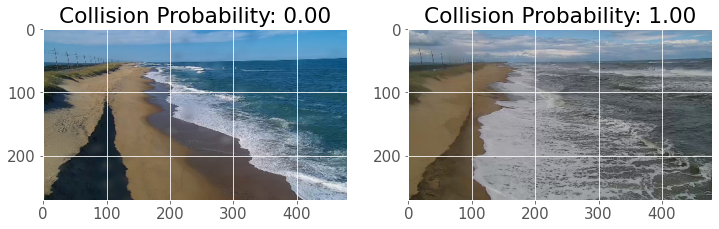

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
f1 = "data/labelled/NoCollision/frame_10000.jpg"
f2 = "data/labelled/CollisionOrClose/frame_10000.jpg"
im = resize(plt.imread(f1)[None,:], (img_height, img_width)) / 255
ax[0].imshow(im[0, :, :, :])
ax[0].set_title(f'Collision Probability: {1-model.predict(im)[0][0]:.2f}')
im = resize(plt.imread(f2)[None,:], (img_height, img_width)) / 255
ax[1].imshow(im[0, :, :, :])
ax[1].set_title(f'Collision Probability: {1-model.predict(im)[0][0]:.2f}');

- Now let's check out the distribution of probabilistic predictions across all of the training data. Ideally, these distributions should peak at Pr(1) for non-collision images and Pr(0) for collision images.
- But note that I'm only using a very simple model here, we could probably do much better...

In [28]:
# image folder
folder_paths = ['data/labelled/NoCollision/',
                'data/labelled/CollisionOrClose/']

# load all images into a list
p = {}
for folder_path in folder_paths:
    images = []
    for img in os.listdir(folder_path):
        try:
            img = os.path.join(folder_path, img)
            img = image.load_img(img, target_size=(img_height, img_width))
            img = image.img_to_array(img) / 255
            img = np.expand_dims(img, axis=0)
            images.append(img)
        except:
            pass

    # stack up images list to pass for prediction
    images = np.vstack(images)
    p[folder_path] = model.predict(images)

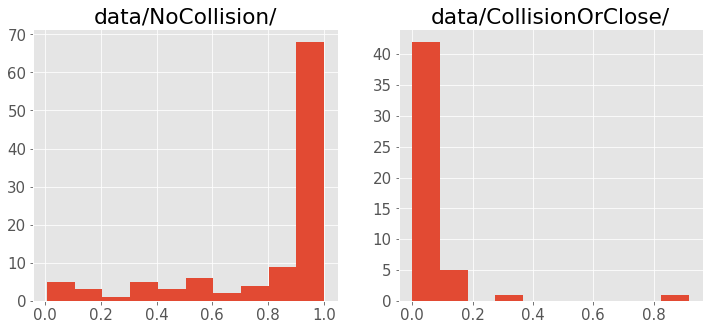

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(p[folder_paths[0]])
ax[0].set_title(folder_paths[0])
ax[1].hist(p[folder_paths[1]])
ax[1].set_title(folder_paths[1]);

# Predict unlabelled data

Okay, we've got a decent (albeit very simple) model working here. Let's do some pseudo-labelling. The process is as follows:

1. Download a bunch of unlabelled data;
2. Use our model to predict the label of this unlabelled data;
3. If the model is very sure of it's prediction (say, *P* > 0.99), assume the label is correct and assign it to the image.

## Download data

Historical footage availability for different stations can be viewed [here](http://webcat-video.axds.co/status/).

For the Buxton Coastal Cam, data is available from August 2018 to the present. You can bulk download images using something like the following command (which downloads all available images for 2019 at 100 second intervals:

```sh
!pywebcat -dir data/Unlabelled/ -s buxtoncoastalcam -y 2019 -m $(seq 1 12) -d $(seq 1 31) -t 1200 -i 100
```

For testing the pseudo-labelling workflow, I'm going to work with just a few images (add the argument `-v` to see verbose output).

In [36]:
!pywebcat -dir data/unlabelled/ -s buxtoncoastalcam -y 2018 -m $(seq 8) -d $(seq 1 10) -t 1200 -i 100

## Create Pseudo Labels

In [80]:
threshold = 0.995  # threshold for pseudo-labelling

In [43]:
# create generator for the test data
image_generator = image.ImageDataGenerator(rescale=1./255)
test_generator = image_generator.flow_from_directory(
    "data/unlabelled",
    target_size=(img_height, img_width),
    class_mode='binary') # set as training data

Found 55 images belonging to 1 classes.


In [44]:
filenames = test_generator.filenames
predictions = model.predict(test_generator)

In [84]:
df = pd.DataFrame({'filename': filenames,
                   'prediction': predictions[:, 0],
                   'label': 'Unlabelled'})
df.loc[df['prediction'] >= threshold, 'label'] = 'NoCollision'
df.loc[df['prediction'] <= (1-threshold), 'label'] = 'CollisionOrClose'
summary = np.unique(df['label'], return_counts=True)
pd.DataFrame(summary[1], summary[0], columns=['Count'])

,Count
NoCollision,13
Unlabelled,42


- From here, we can move all the labelled files to new "pseudo-labelled" folders (or the existing labelled folders)
- We should probably save the model too